In [30]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from pygdsm import GlobalSkyModel
import uvtools
import healpy as hp
from scipy.interpolate import RectBivariateSpline
import aipy

In [31]:
CST_PATH = '../../CST_Beams/simple_vivaldi_model/Farfield/'
beamfiles = sorted(glob.glob(CST_PATH + '*.txt'))
beamfiles = beamfiles[-50:] + beamfiles[:-50]
beamfiles = beamfiles[:-1]

In [32]:
THETA_AXIS = 0
PHI_AXIS = 1
VOLT_AXIS = 2
freqs = np.array([float(f.split()[1][3:-1]) for f in beamfiles]) / 1000 # GHz
thetas, phis = np.loadtxt(beamfiles[0], skiprows=2, usecols=(THETA_AXIS,PHI_AXIS)).T
thetas = np.deg2rad(np.unique(thetas))
phis = np.deg2rad(np.unique(phis))
data = np.array([np.loadtxt(f, skiprows=2, usecols=VOLT_AXIS) for f in beamfiles])
data.shape = (-1, phis.size, thetas.size)

In [33]:
NPIX = 129
L = np.linspace(-1, 1, NPIX,endpoint=True)
M = np.linspace(-1, 1, NPIX,endpoint=True)
L.shape = (-1, 1)
M.shape = ( 1,-1)
L = L * np.ones_like(M)
M = M * np.ones_like(L)
LM = L**2 + M**2
N = np.where(LM < 1, np.sqrt(1 - LM), 0)
th = np.arccos(L).flatten()
ph = np.arctan2(M, N).flatten() - np.pi
ph = np.where(ph < 0, 2*np.pi+ph, ph)

<ipython-input-33-10d1e12bae00>:9: RuntimeWarning: invalid value encountered in sqrt
  N = np.where(LM < 1, np.sqrt(1 - LM), 0)


In [34]:
mask = np.where(LM < 1, 1, 0)
beams = np.array([RectBivariateSpline(phis, thetas, d)(ph, th, grid=False)**2 for d in data])
beams.shape = (-1, NPIX, NPIX)
beams *= mask
print(beams.shape)

(200, 129, 129)


<IPython.core.display.Javascript object>


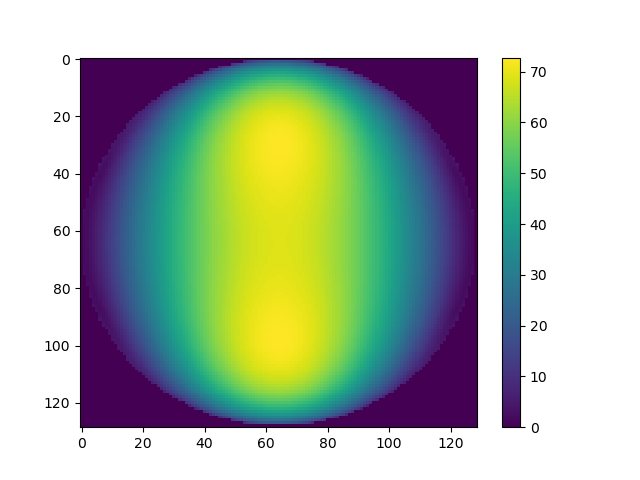

In [35]:
plt.figure()
uvtools.plot.waterfall(beams[100], mode='real')
plt.colorbar()

# Load up GSM

In [36]:
NSIDE = 64
hpb = aipy.healpix.HealpixBase(nside=NSIDE)
I_sky = np.empty((freqs.size, hpb.npix()))
gsm = GlobalSkyModel(freq_unit='GHz')
ga2eq = aipy.coord.convert_m('ga', 'eq')
for ch,f in enumerate(freqs):
    if NSIDE == 512:
        I_sky[ch] = gsm.generate(f)
    else:
        I_sky[ch] = hp.ud_grade(gsm.generate(f), nside_out=NSIDE)

In [37]:
NTIMES = 256
JD = 2459117
jds = np.linspace(JD, JD+1, NTIMES)

crd_eq = np.array(hpb.px2crd(np.arange(hpb.npix())))
antpos = np.array([[0.,0,0]]) # meters
loc = ('40:00', '0:00')
aa = aipy.amp.AntennaArray(loc, antpos)

eq2tops = []
for jd in jds:
    aa.set_jultime(jd)
    eq2tops.append(np.dot(aa.eq2top_m, ga2eq))
eq2tops = np.array(eq2tops)

<IPython.core.display.Javascript object>


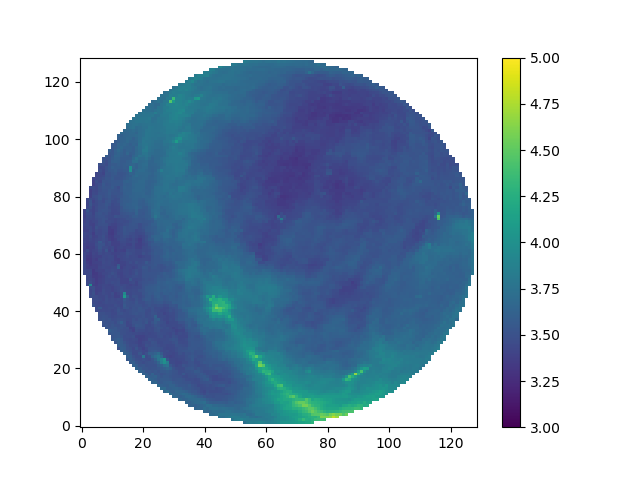

In [43]:
hpm = aipy.healpix.HealpixMap(nside=NSIDE)
hpm.map = I_sky[0]
top = (M.flatten(), L.flatten(), N.flatten())
gx,gy,gz = np.dot(np.linalg.inv(np.dot(eq2tops[150], ga2eq)), top)
img = hpm[gx,gy,gz]
img.shape = (NPIX,NPIX)
plt.figure()
uvtools.plot.waterfall(mask * img, mode='log', mx=5, drng=2, origin='lower')
_ = plt.colorbar()

In [44]:
if not os.path.exists('auto.npz'):
    #from hera_gpu.vis import vis_gpu as vis
    from hera_sim.visibilities.vis_cpu import vis_cpu as vis

    data = np.empty((NTIMES,freqs.size), dtype=np.complex64)
    for ch in range(freqs.size):
        print(ch)
        data[:,ch] = vis(antpos, freqs[ch], eq2tops, crd_eq, I_sky[ch], beams[ch:ch+1])[:,0,0]
    np.savez('auto.npz', data=data, freqs=freqs, jds=jds)
else:
    print('Reading from file')
    npz = np.load('auto.npz')
    data = npz['data']
    jds = npz['jds']
    freqs = npz['freqs']

Reading from file


In [334]:
def dayenu(dat, width=1.):
    _, rdat, _ = uvtools.dspec.fourier_filter(
                                x=freqs * 1e9,
                                data=dat,
                                wgts=np.ones_like(dat),
                                mode='dpss_leastsq',
                                filter_centers=[0.],
                                filter_half_widths=[width * 1e-9],
                                eigenval_cutoff=[1e-12],
                                suppression_factors=[1e-9]
    )
    return rdat

rdata = dayenu(data / data[55]) * data[55]

In [153]:
ARES_PATH = '../../Cosmology_Models/'
models = np.load(ARES_PATH + 'models_21cm.npz')['models'] / 1e3 # K
mfreqs = np.load(ARES_PATH + 'models_21cm.npz')['freqs']

In [306]:
gain = beams[:,NPIX//2+1,NPIX//2+1]
avg = np.mean(data[-50:], axis=0) / gain
cal = 180 / avg[np.argmin(np.abs(freqs-0.180))]
idata = cal * data / gain + fake_eor

<IPython.core.display.Javascript object>


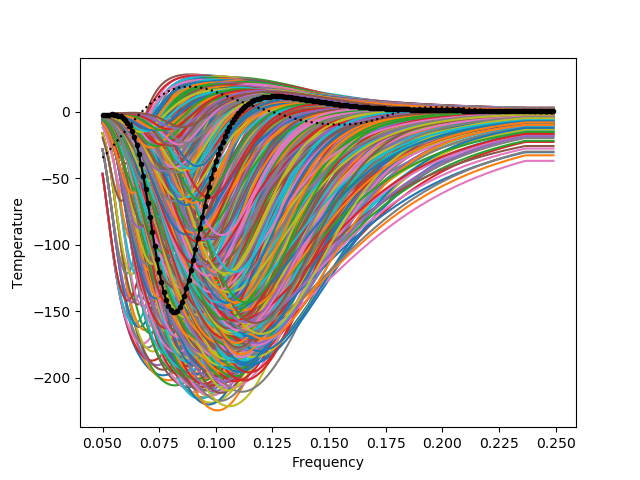

In [534]:
def gen_eor(A, nu0, w, tau):
    B = 4 * (freqs - nu0)**2 / w**2 * np.log(-1/tau * np.log((1+np.exp(-tau))/2))
    return -A * (1 - np.exp(-tau * np.exp(B))) / (1 - np.exp(-tau))

prms = {
    'A': 0.52,
    'nu0': 78.3e-3,
    'w': 20.7e-3,
    'tau': 6.5,
}
#fake_eor = gen_eor(**prms)
#fake_eor = models[185]
fake_eor = models[78]

plt.figure()

for mdl in models:
    plt.plot(freqs, 1e3*mdl)
plt.plot(freqs, 1e3*fake_eor, 'k.-')
plt.plot(freqs, idata[0], 'k:')

plt.xlabel('Frequency')
_ = plt.ylabel('Temperature')

In [535]:
#def dayenu(data):
#    return data

idata = cal * data / gain + fake_eor

# Build a filter to exclude EoR from calibration signal
d = idata - np.mean(idata[-50:], axis=0)
C = np.dot(d.T, d)
U,S,V = np.linalg.svd(C)
#plt.figure(); plt.plot(S)
iS = np.identity(S.size)
#iS[10:,10:] = 0
iS[5:,5:] = 0
Cinv = np.dot(V.T, np.dot(iS, U.T))
#pcal = idata[55] - 0.5 * fake_eor # XXX
pcal = np.dot(Cinv, idata[55]) # filter to exclude most of eor signal

reor = dayenu(fake_eor / pcal) * pcal
rmodels = dayenu(models / pcal) * pcal

idata = dayenu(idata / pcal) * pcal

<IPython.core.display.Javascript object>


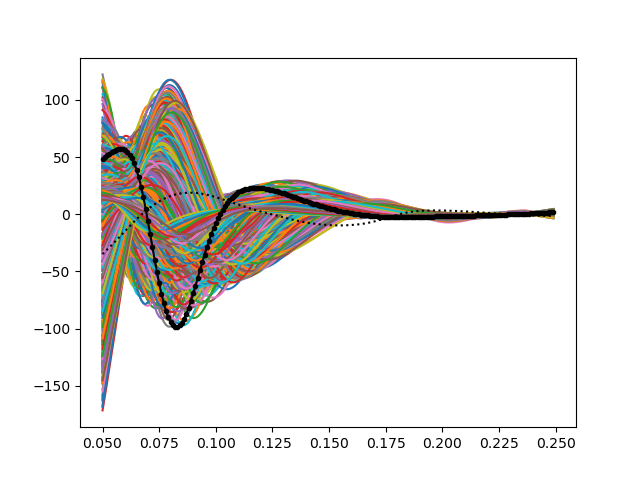

In [536]:
plt.figure()
for mdl in rmodels:
    plt.plot(freqs, 1e3*mdl)
plt.plot(freqs, 1e3*reor, 'k.-')
plt.plot(freqs, idata[0], 'k:')

In [537]:
d = idata - np.mean(idata[-50:], axis=0)
C = np.dot(d.T, d)
U,S,V = np.linalg.svd(C)

In [538]:
m = rmodels - np.mean(rmodels, axis=0)
Cm = np.dot(m.T, m)
Um, Sm, Vm = np.linalg.svd(Cm)

<IPython.core.display.Javascript object>


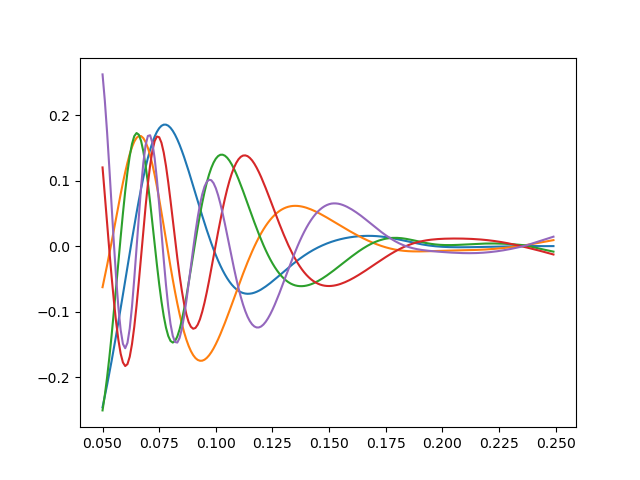

In [539]:
plt.figure()
_ = plt.plot(freqs, Vm[:5].T)

<IPython.core.display.Javascript object>


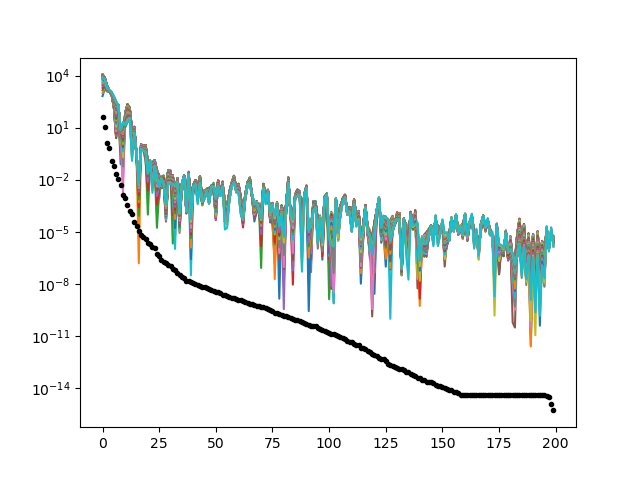

In [540]:
plt.figure()
plt.semilogy(np.abs(np.dot(Vm, idata[-50:].T))**2)
_ = plt.semilogy(Sm, 'k.')

<IPython.core.display.Javascript object>


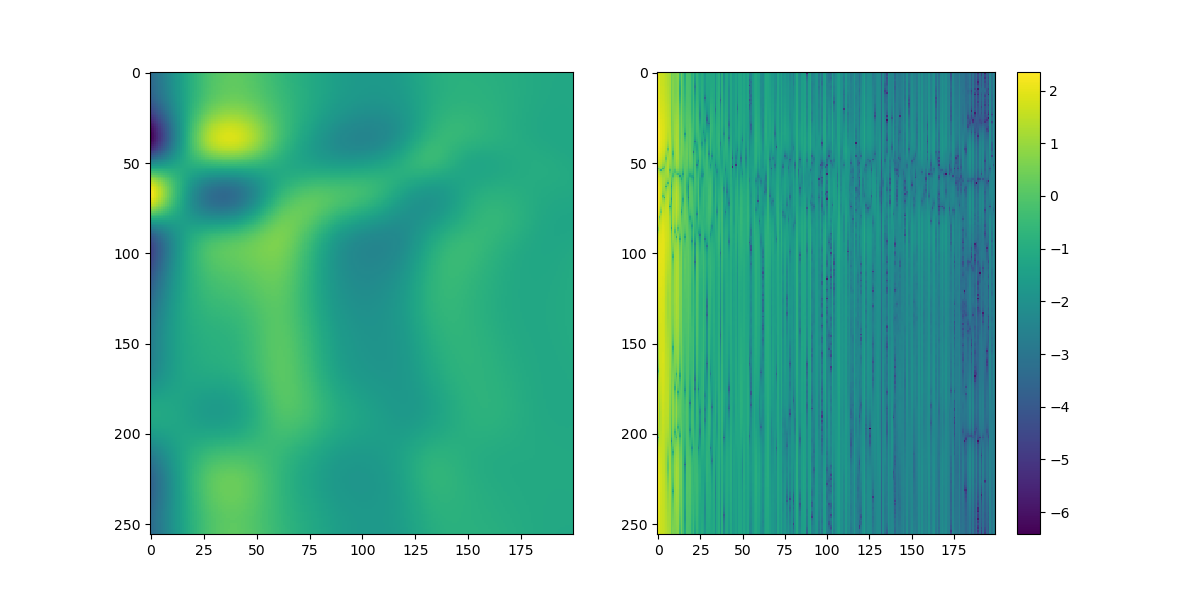

In [541]:
plt.figure(figsize=(12,6))
plt.subplot(121)
uvtools.plot.waterfall(idata, mode='real')
plt.subplot(122)
uvtools.plot.waterfall(np.dot(Vm, idata.T).T, mode='log')
_ = plt.colorbar()

<IPython.core.display.Javascript object>


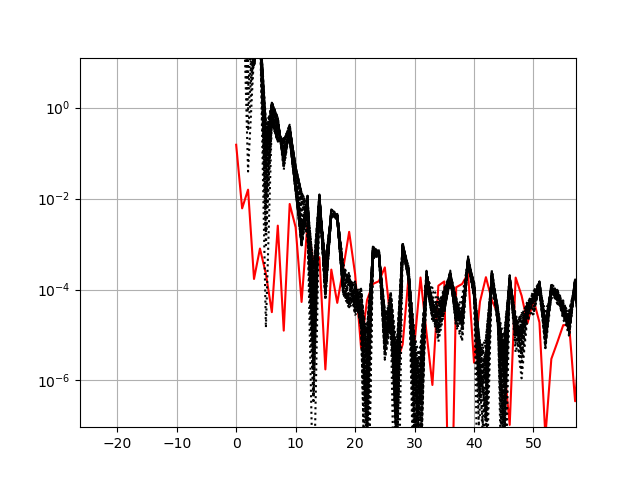

(646, 200)


In [542]:
plt.figure()
print(rmodels.shape)
#plt.semilogy(np.abs(np.dot(V, rmodels[78:79].T))**2)
plt.semilogy(np.abs(np.dot(V, reor))**2,'r')
#plt.semilogy(S, 'k.-')
plt.semilogy(np.abs(np.dot(V, (idata[-50:] - reor).T))**2, 'k:')
#plt.semilogy(np.abs(np.dot(V, (idata[-50:]).T))**2, 'r:')
plt.grid()

In [543]:
iS = np.identity(S.size)
#np.fill_diagonal(iS, np.where(S > 1e12, 1e12/S, 1))
#np.fill_diagonal(iS, 4e-7/S.clip(4e-7, np.Inf))
iS[:18,:18] = 0
#iS[:16,:16] = 0
Cinv = np.dot(V.T, np.dot(iS, U.T))

<IPython.core.display.Javascript object>


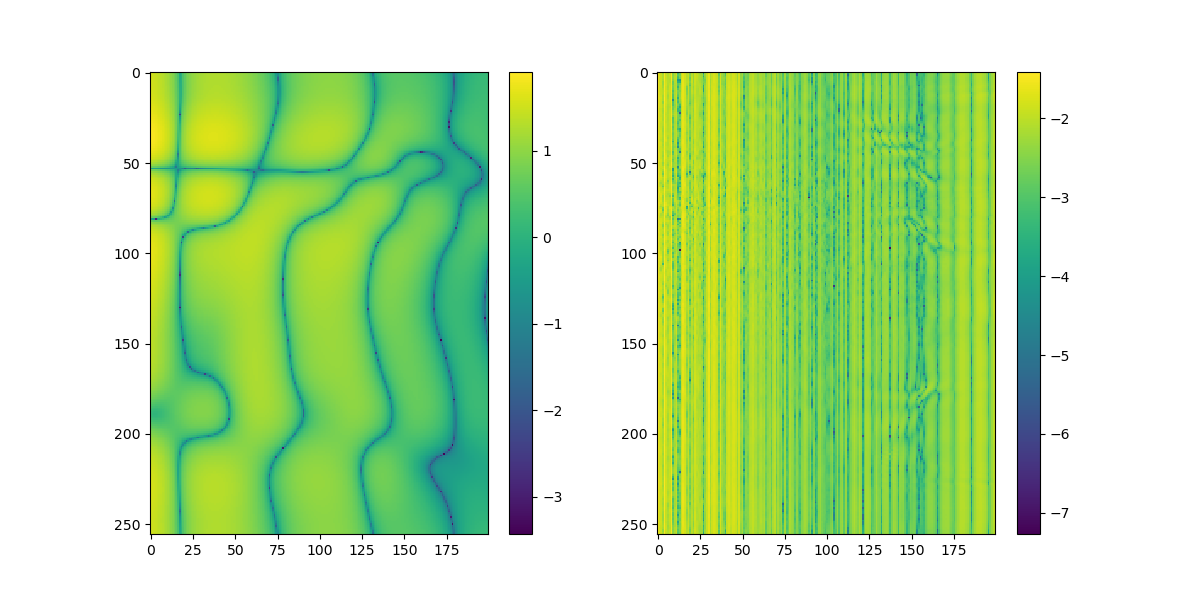

In [544]:
plt.figure(figsize=(12,6))
plt.subplot(121)
uvtools.plot.waterfall(idata, mode='log')
plt.colorbar()
plt.subplot(122)
uvtools.plot.waterfall(np.dot(Cinv, idata.T).T, mode='log')
plt.colorbar()

<IPython.core.display.Javascript object>


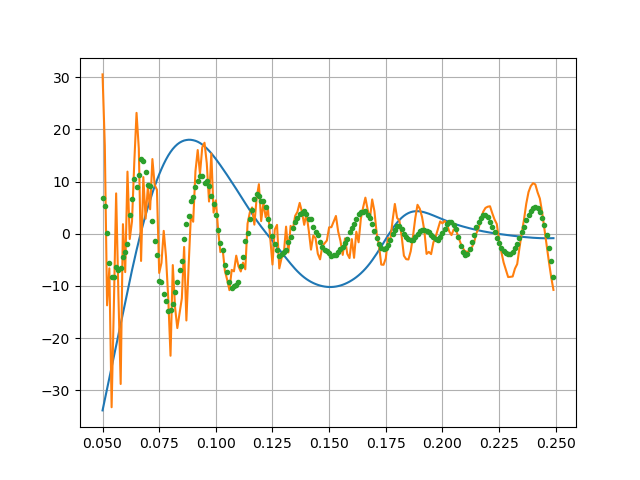

In [545]:
plt.figure()
plt.plot(freqs, np.mean(idata[-50:], axis=0))
plt.plot(freqs, 1e3*np.mean(np.dot(Cinv, idata[-50:].T).T, axis=0))
plt.plot(freqs, 1e3*np.dot(Cinv, reor), '.')
plt.grid()

In [546]:
detect = np.mean(np.dot(Cinv, idata.T).T, axis=0)
template = np.dot(Cinv, reor)
print(np.dot(detect, template) / np.dot(template, template))

(1.0422329104738215+0j)
